# Adversarial Learning

In this notebook, we will go through basics of Adversarial Learning through two attacks - non-targeted and targeted attacks on a given input car image. We will use two libraries - cleverhans and foolbox. 

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/adversarial/learning/2019/03/04/Mystery-of-Adversarial-Learning/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Adversarial%20Learning/adv_learning_pytorch.ipynb)





In [2]:
#upload input image 

from google.colab import files
files.upload()

{}

In [0]:
!pip install cleverhans

    100% |████████████████████████████████| 204kB 25.9MB/s 
    100% |████████████████████████████████| 51kB 21.7MB/s 


In [0]:
!pip install foolbox

    100% |████████████████████████████████| 245kB 7.7MB/s 
    100% |████████████████████████████████| 450kB 29.6MB/s 
    100% |████████████████████████████████| 71kB 28.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/d7/e7/c8/153284a6e5e5c3fd4da42a8453175b45e2e185e8b5a09ced06
Successfully built foolbox


In [0]:
from io import BytesIO
import IPython.display
import foolbox
from foolbox.criteria import TargetClassProbability
import tensorflow as tf
import torch
from torch import nn
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.inception import inception_v3
from cleverhans.attacks import FastGradientMethod
from cleverhans.model import CallableModelWrapper
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
incept_model = inception_v3(pretrained=True, transform_input=True).cuda()
loss = nn.CrossEntropyLoss()
incept_model.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
108857766it [00:01, 86854154.66it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
trans = T.Compose([T.ToTensor(), T.Lambda(lambda t: t.unsqueeze(0))])
reverse_trans = lambda x: np.asarray(T.ToPILImage()(x))

def load_image(img_path):
    img = trans(Image.open(img_path).convert('RGB'))
    print (img.shape)
    return img

torch.Size([1, 3, 299, 299])


([], <a list of 0 Text yticklabel objects>)

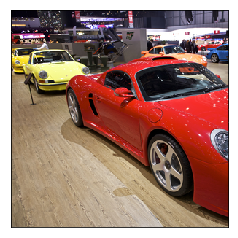

In [0]:
img_path = 'input.png'
x = load_image(img_path)
plt.imshow(reverse_trans(x[0]))
plt.xticks([])
plt.yticks([])

In [0]:
preds = incept_model(x.cuda())

In [0]:
print('Inception Prediction:', preds.data.max(1)[1].cpu().numpy()[0])

Inception Prediction: 817


# Non-targeted Adversarial Attack

Kaggle Competition : [Link](https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack/)

The non-targeted challenge focuses on tricking the classifier with any other class.


## Using cleverhans library

Code Adapted from: [Link](https://www.kaggle.com/benhamner/adversarial-learning-challenges-getting-started)

In [0]:
# Create TF session and set as Keras backend session
sess = tf.Session()
eps = 0.3

In [0]:
x_input = tf.placeholder(tf.float32, shape=[1, 3, 299, 299])
# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_model_fn = convert_pytorch_model_to_tf(incept_model)
cleverhans_model = CallableModelWrapper(tf_model_fn, output_layer='logits')
fgsm  = FastGradientMethod(cleverhans_model, sess=sess)
x_adv = fgsm.generate(x_input, eps=eps, clip_min=0., clip_max=1.)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
dim is deprecated, use axis instead


In [0]:
session_creator = tf.train.ChiefSessionCreator()

with tf.train.MonitoredSession(session_creator=session_creator) as sess:
    nontargeted_images = sess.run(x_adv, feed_dict={x_input: x})

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
nontargeted_images.shape

(1, 3, 299, 299)

In [0]:
def get_class(img):
    x = Variable(img, volatile=True).cuda()
    cls = incept_model(x).data.max(1)[1].cpu().numpy()[0]
    return cls

def show_image(img, adv_img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    orig_class = get_class(img)
    attack_class = get_class(adv_img)
    ax[0].imshow(reverse_trans(img[0]))
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(reverse_trans(adv_img[0]))
    ax[1].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(2):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

The original image is on the left, and the nontargeted adversarial image is on the right.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


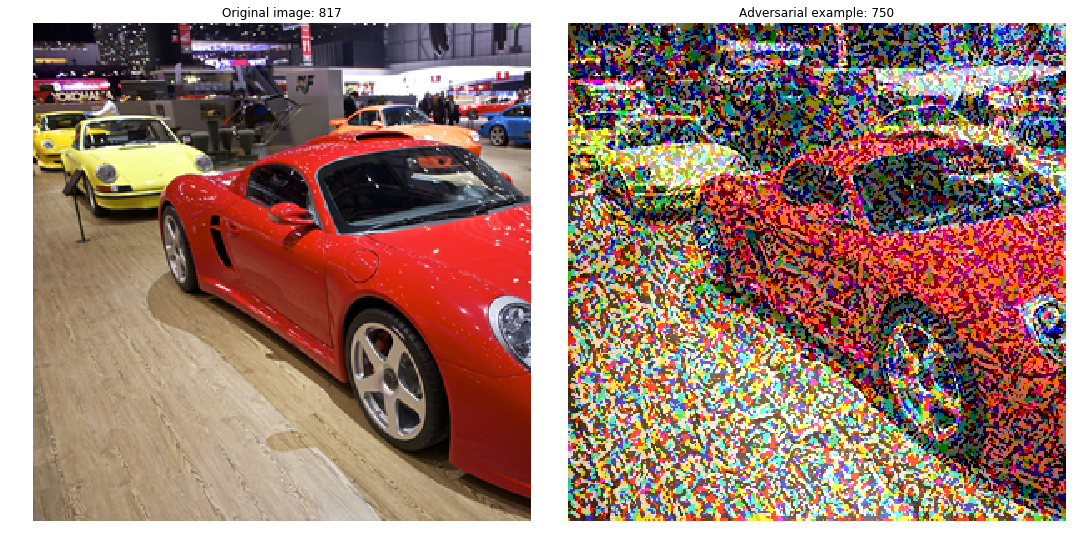

In [0]:
print("The original image is on the left, and the nontargeted adversarial image is on the right.")
show_image(x, torch.Tensor(nontargeted_images))

In [0]:
preds = incept_model(torch.Tensor(nontargeted_images).cuda())

In [0]:
print('Advesarial Prediction:', preds.data.max(1)[1].cpu().numpy()[0])

Advesarial Prediction: 750


## Using foolbox library

Code Adapted from: [Link](https://foolbox.readthedocs.io/en/latest/user/examples.html)

In [0]:
# instantiate the model
fmodel = foolbox.models.PyTorchModel(incept_model, bounds=(0, 1), num_classes=1000)
label = 817
print('Predicted class', np.argmax(fmodel.predictions(np.array(x[0]))))

Predicted class 817


In [0]:
# apply attack on source image
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(np.array(x[0]), label)

In [0]:
print('adversarial class', np.argmax(fmodel.predictions(adversarial)))

adversarial class 751


In [0]:
reverse_trans = lambda x: np.asarray(T.ToPILImage()(x))

def get_class(img):
    cls = np.argmax(fmodel.predictions(img))
    return cls

def show_image(x, adv_img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    orig_class = get_class(np.array(x[0]))
    attack_class = get_class(adv_img)
    ax[0].imshow(reverse_trans(x[0]))
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(np.transpose(adv_img, (1, 2, 0)))
    ax[1].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(2):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

The original image is on the left, and the nontargeted adversarial image is on the right.


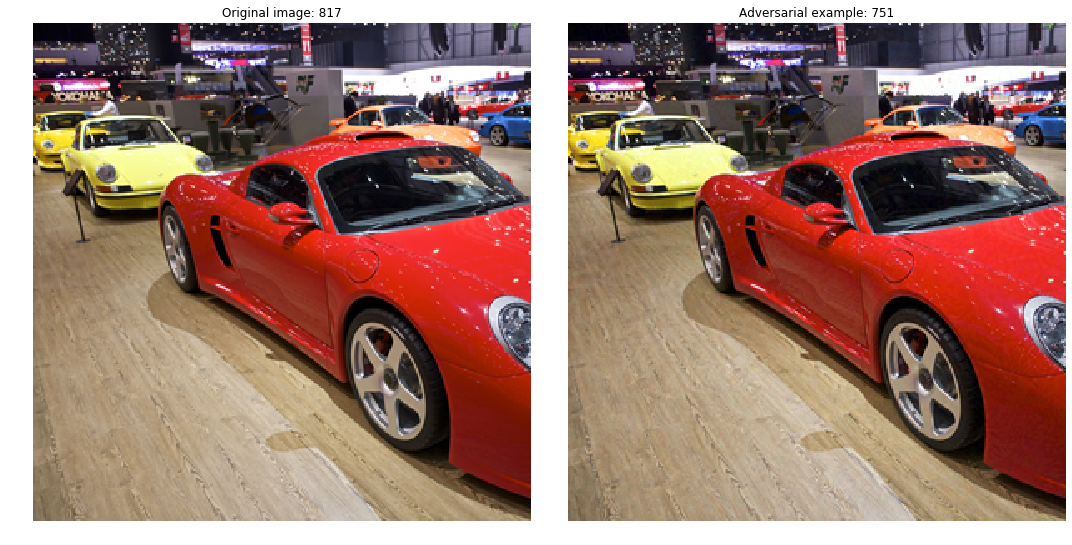

In [0]:
print("The original image is on the left, and the nontargeted adversarial image is on the right.")
show_image(x, adversarial)

## Using Gradients

Code Adapted from: [Link](https://github.com/Lextal/adv-attacks-pytorch-101/blob/master/imagenet/introduction.ipynb)


In [0]:
steps = 40
step_alpha = 0.01
eps = 2 * 8 / 225.

In [0]:
def get_class(img):
    x = Variable(img, volatile=True).cuda()
    cls = incept_model(x).data.max(1)[1].cpu().numpy()[0]
    return cls

def show_image(img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(img), get_class(adv_img)
    ax[0].imshow(reverse_trans(img[0]))
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(reverse_trans(noise[0]))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(reverse_trans(adv_img[0]))
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [0]:
def non_targeted_attack(img):
    img = img.cuda()
    label = torch.zeros(1, 1).cuda()
    
    x, y = Variable(img, requires_grad=True), Variable(label)
    for step in range(steps):
        print ("Step:", step)
        zero_gradients(x)
        out = incept_model(x)
        y.data = out.data.max(1)[1]
        _loss = loss(out, y)
        _loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data + normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result
    return result.cpu(), adv.cpu()

In [0]:
adv_img, noise = non_targeted_attack(x)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39


In [0]:
x.shape, noise.shape, adv_img.shape

(torch.Size([1, 3, 299, 299]),
 torch.Size([1, 3, 299, 299]),
 torch.Size([1, 3, 299, 299]))

The original image is on the left, and the nontargeted adversarial image is on the right.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


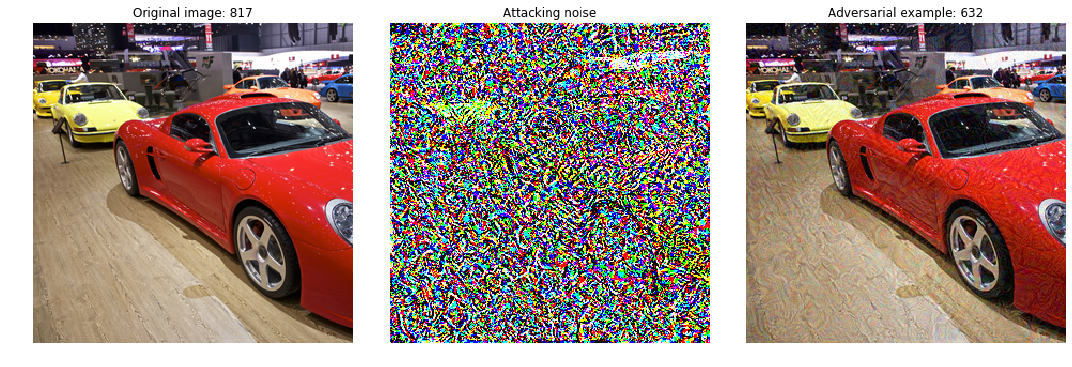

In [0]:
print("The original image is on the left, and the nontargeted adversarial image is on the right.")
show_image(x, noise, adv_img)

In [0]:
preds = incept_model(adv_img.cuda())

In [0]:
print('Non-targeted Advesarial Prediction:', preds.data.max(1)[1].cpu().numpy()[0])

Non-targeted Advesarial Prediction: 632


# Targeted Adversarial Attack

Kaggle Competition : [Link](https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack/)

## Using foolbox library

Code Adapted from : [Link](https://foolbox.readthedocs.io/en/latest/user/examples.html)

In [0]:
# instantiate the model
fmodel = foolbox.models.PyTorchModel(incept_model, bounds=(0, 1), num_classes=1000)
label = 817
print('Predicted class', np.argmax(fmodel.predictions(np.array(x[0]))))

Predicted class 817


In [0]:
# apply attack on source image
attack = foolbox.attacks.LBFGSAttack(model=fmodel, criterion=TargetClassProbability(859, p=.5))
adversarial = attack(np.array(x[0]), label)

In [0]:
print('adversarial class', np.argmax(fmodel.predictions(adversarial)))
print('adversarial class probability', foolbox.utils.softmax(fmodel.predictions(adversarial))[859])

adversarial class 859
adversarial class probability 0.6563251


In [0]:
reverse_trans = lambda x: np.asarray(T.ToPILImage()(x))

def get_class(img):
    cls = np.argmax(fmodel.predictions(img))
    return cls

def show_image(x, adv_img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    orig_class = get_class(np.array(x[0]))
    attack_class = get_class(adv_img)
    ax[0].imshow(reverse_trans(x[0]))
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(np.transpose(adv_img, (1, 2, 0)))
    ax[1].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(2):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

The original image is on the left, and the nontargeted adversarial image is on the right.


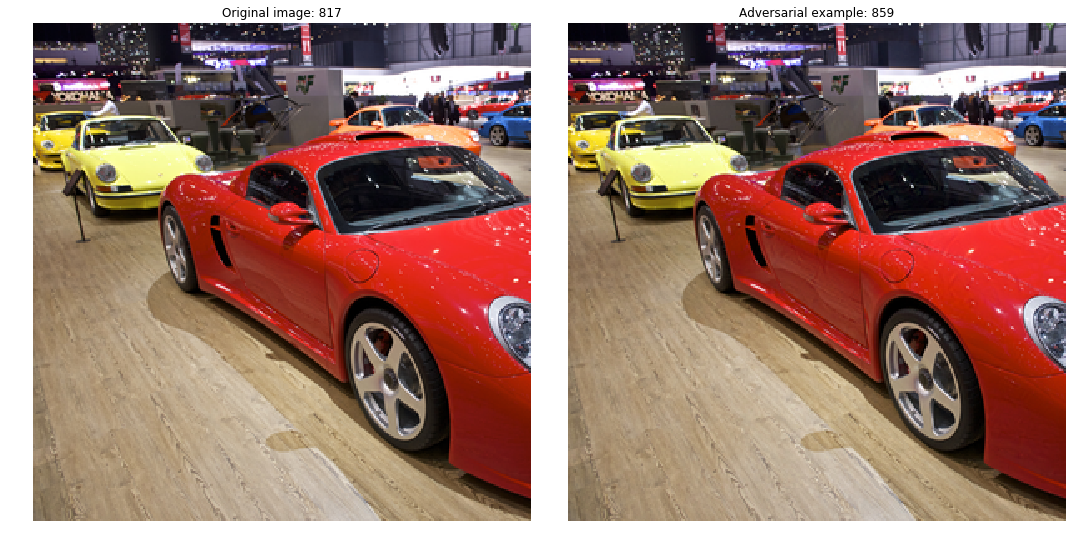

In [0]:
print("The original image is on the left, and the nontargeted adversarial image is on the right.")
show_image(x, adversarial)

## Using Gradients

Code Adapted from: [Link](https://github.com/Lextal/adv-attacks-pytorch-101/blob/master/imagenet/introduction.ipynb)


In [0]:
steps = 10
step_alpha = 0.01
eps = 2 * 8 / 225.

In [0]:
def get_class(img):
    x = Variable(img, volatile=True).cuda()
    cls = incept_model(x).data.max(1)[1].cpu().numpy()[0]
    return cls

def show_image(img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(img), get_class(adv_img)
    ax[0].imshow(reverse_trans(img[0]))
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(reverse_trans(noise[0]))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(reverse_trans(adv_img[0]))
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [0]:
def targeted_attack(img, label):
    img = img.cuda()
    label = torch.Tensor([label]).long().cuda()
    
    x, y = Variable(img, requires_grad=True), Variable(label)
    for step in range(steps):
        print ("Step:", step)
        zero_gradients(x)
        out = incept_model(x)
        _loss = loss(out, y)
        _loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data - normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result
    return result.cpu(), adv.cpu()


In [0]:
targeted_adv_img, noise = targeted_attack(x, 859)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9


In [0]:
x.shape, noise.shape, targeted_adv_img.shape

(torch.Size([1, 3, 299, 299]),
 torch.Size([1, 3, 299, 299]),
 torch.Size([1, 3, 299, 299]))

The original image is on the left, and the nontargeted adversarial image is on the right.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


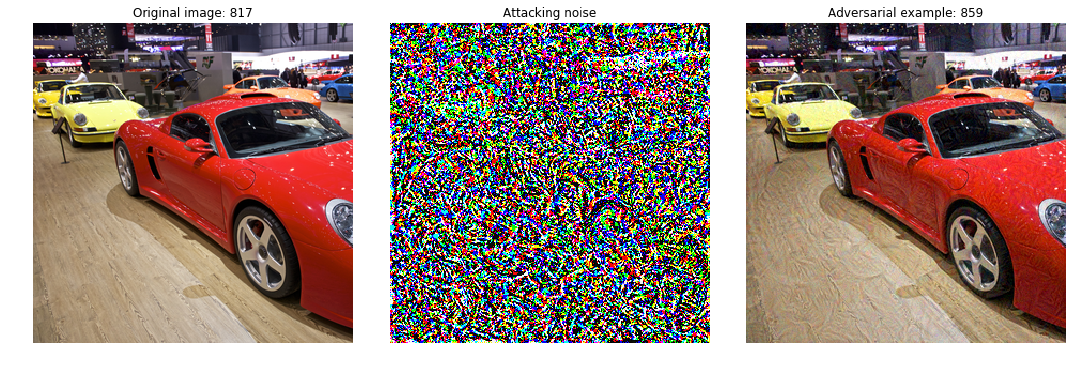

In [0]:
print("The original image is on the left, and the nontargeted adversarial image is on the right.")
show_image(x, noise, targeted_adv_img)

In [0]:
preds = incept_model(targeted_adv_img.cuda())

In [0]:
print('Targeted Advesarial Prediction:', preds.data.max(1)[1].cpu().numpy()[0])

Targeted Advesarial Prediction: 859
